### Gensim LDA

#### Imports

In [4]:
import re, os, time
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
from gensim.models.ldamodel import LdaModel
from gensim.models import Phrases
from gensim.models.phrases import Phraser
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# Import nltk stopwords and spacy for lemmatization
from nltk.corpus import stopwords

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
import spacy
%matplotlib inline

import warnings
warnings.filterwarnings('ignore',category=DeprecationWarning)

C:\Users\Mikhail\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
current_dir = os.getcwd()
os.chdir(current_dir)

#### 1. Import and preprocess dataset 

First of all, we need to load and preprocess the data. All Tweets were collected and stored in _JSON_ (JavaScript Object Notation) format. As reference: "JSON is a lightweight data-interchange format. It is easy for humans to read and write. It is easy for machines to parse and generate.". After loading it, we want to manipulate the data in _lists_ and _dictionaries_. In addition, we will collect statistics about the dataset.

In [3]:
# Collect names of Tweet files
from os import listdir
from os.path import isfile, join

mypath = 'data/elections'
onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]

In [4]:
# Collect all Tweets available and store them as list of dicts
import json
all_tweets = []

for f in onlyfiles:
    full_name = mypath+'/'+f

    with open(full_name, 'r') as f:
        data = json.load(f)
        all_tweets.extend(data)

In [5]:
# # Save collected Tweets
# import json
# with open('elections_tweets', 'w') as fout:
#     json.dump(all_tweets, fout)

In [7]:
# Load collected Tweets
import json
with open('elections_tweets_all_lang', 'r') as fout:
        all_tweets = json.load(fout)

In [8]:
# # Load collected Tweets sorted by political party
# import json
# with open('dutch_only_party_text.json', 'r') as fout:
#         tweets_by_party = json.load(fout)
# tweets_by_party.keys()

It turned out that some Tweets are non-Dutch. For the algorithm it is important to have words from a single language. So, before proceed further we need to clean up the dataset.

In [9]:
# Let's see how many of them in Dutch
l = []
k = 0
for i in range(len(all_tweets)) : 
    if (all_tweets[i]['lang'] != 'nl') : 
        k = k + 1
        l.append(all_tweets[i]['lang'])
print(len(all_tweets), 'Tweets collected')
print(k, 'out of them are non-Dutch')
print('Thus, we have', len(all_tweets) - len(l), 'Dutch Tweets')

796460 Tweets collected
80792 out of them are non-Dutch
Thus, we have 715668 Dutch Tweets


In [3]:
# Here we can see their language
# pprint(set(l))

In [10]:
# Let's exclude non-Dutch Tweets
dutch_tweets = []
for i in range(len(all_tweets)) : 
    if (all_tweets[i]['lang'] == 'nl') :
        dutch_tweets.append(all_tweets[i])

In [11]:
from collections import Counter
Counter(l).keys() # see languages

dict_keys(['und', 'fr', 'en', 'hi', 'tr', 'sv', 'da', 'es', 'et', 'in', 'ru', 'de', 'fi', 'tl', 'ht', 'it', 'hu', 'ja', 'no', 'lt', 'pt', 'eu', 'cy', 'pl', 'lv', 'vi', 'cs', 'ro', 'ca', 'th', 'ko', 'sl', 'is', 'ar', 'ur', 'iw', 'zh', 'bg', 'uk', 'el', 'fa', 'hy'])

In [12]:
Counter(l).values() # how many per language

dict_values([19042, 2701, 15414, 56, 1923, 279, 643, 8220, 442, 1355, 76, 2502, 202, 190, 247, 4719, 52, 12359, 906, 34, 6246, 77, 51, 915, 55, 18, 279, 120, 109, 645, 329, 75, 16, 423, 10, 2, 31, 5, 11, 11, 1, 1])

In [7]:
# # Save Dutch-only Tweets
# with open('elections_tweets_dutch', 'w') as fout:
#     json.dump(dutch_tweets, fout)

In [2]:
# Load Dutch-only Tweets
import json
with open('elections_tweets_dutch_only', 'r') as fout:
        all_tweets = json.load(fout)

In [5]:
# Statistics
print('Sample of a Tweet:', all_tweets[0]['text'], '\n')
print('Number of fields available:', len(all_tweets[0].keys()), '\n')
print('Fields available in a Tweet:', '\n', [*all_tweets[0]], '\n')
print('Info avaialable in the whole set:', '\n', pd.DataFrame(all_tweets[:10]).columns.values)

Sample of a Tweet: RT @Derksen_Gelul: Nederlands bekendste droogkloot, Marcel van Roosmalen sloopt D66 helemaal de moeder!! Luister zelf naar deze topper en g… 

Number of fields available: 28 

Fields available in a Tweet: 
 ['created_at', 'id', 'id_str', 'text', 'source', 'truncated', 'in_reply_to_status_id', 'in_reply_to_status_id_str', 'in_reply_to_user_id', 'in_reply_to_user_id_str', 'in_reply_to_screen_name', 'user', 'geo', 'coordinates', 'place', 'contributors', 'retweeted_status', 'is_quote_status', 'quote_count', 'reply_count', 'retweet_count', 'favorite_count', 'entities', 'favorited', 'retweeted', 'filter_level', 'lang', 'timestamp_ms'] 

Info avaialable in the whole set: 
 ['contributors' 'coordinates' 'created_at' 'display_text_range' 'entities'
 'extended_tweet' 'favorite_count' 'favorited' 'filter_level' 'geo' 'id'
 'id_str' 'in_reply_to_screen_name' 'in_reply_to_status_id'
 'in_reply_to_status_id_str' 'in_reply_to_user_id'
 'in_reply_to_user_id_str' 'is_quote_status' 'l

In [5]:
# Extract the data (id and text), and put it into dict and list
text_dict = {} 
text_list = []
id_list = []
missing_tweets = 0

for tweet in all_tweets:
    if ('text' in tweet.keys()):
        if ('id' in tweet.keys()):
            my_id = tweet['id']
            if (tweet['text'] != None):
                text_dict[my_id] = tweet['text']
                id_list.append(my_id)
                text_list.append([tweet['text']])
                
            elif (tweet['text'] == None):
                missing_values = missing_tweets + 1

In [8]:
# # Save processed Tweets
# import pickle

# with open('elections_text_list', 'wb') as fp:
#     pickle.dump(text_list, fp)
    
# with open('elections_text_dict', 'wb') as fp:
#     pickle.dump(text_dict, fp, protocol=pickle.HIGHEST_PROTOCOL)

In [1]:
# Load processed Tweets
import pickle
with open('elections_text_list', 'rb') as fp:
    text_list = pickle.load(fp)
    
with open('elections_text_dict', 'rb') as fp:
    text_dict = pickle.load(fp)

In [2]:
# Statistics
t = len(text_dict)
max_length = 0
average_length = 0

for tweet in text_list : 
    average_length = average_length + sum(len(i) for i in tweet) 
    if (sum(len(i) for i in tweet) > max_length) : 
        max_length = sum(len(i) for i in tweet)
        max_tweet = tweet

print('In total ' + str(t) + ' Tweets to be processed')
print('On average Tweet is ' + str(round(average_length / t)) + ' charachters long', '\n')
print('Longest Tweet is:', max_tweet, '\n')
print('It is', sum(len(i) for i in max_tweet), 'characters long')

In total 715155 Tweets to be processed
On average Tweet is 126 charachters long 

Longest Tweet is: ['RT @RoosjeXS: &amp;#39;Als angst mijn&amp;nbsp;raadgever wordt,&amp;nbsp;dan moet ik&amp;nbsp;meteen iets anders&amp;nbsp;gaan doen.&amp;#39; - Sigrid Kaag https:/…'] 

It is 164 characters long


In [5]:
# Let's inspect the Tweets
pd.DataFrame(text_list[:5])

,0
0,RT @Derksen_Gelul: Nederlands bekendste droogk...
1,"RT @GerBStruik: Niet alleen Ollongren, maar ni..."
2,"@JoostNiemoller Joost, trap er toch niet in. H..."
3,@EenVandaag @thierrybaudet @D66 @APechtold Ald...
4,Dolhuysbrug moet na tien jaar definitief van t...


#### 2. Remove emails and newline characters 

Now it is time to preprocess the Tweets. We will exclude some symbols, links, etc. Thereafter for algorithmic purposes, we need to split each Tweet (a combination of sentences) into a combination of words.

In [6]:
# Before
pprint(text_list[:3])

[['RT @Derksen_Gelul: Nederlands bekendste droogkloot, Marcel van Roosmalen '
  'sloopt D66 helemaal de moeder!! Luister zelf naar deze topper en g…'],
 ['RT @GerBStruik: Niet alleen Ollongren, maar niemand in #Rutte3 heeft '
  'kennelijk enig benul van staatsrecht. Een minister die als minister ee…'],
 ['@JoostNiemoller Joost, trap er toch niet in. Hier is één grote minne '
  'manipulatie aan de gang tegen FVD. Deze heeft… https://t.co/lVFOuFFYF3']]


In [7]:
data = text_list
# data = text_list[-int(1e5):]

# Remove Emails and links to users
data = [re.sub('\S*@\S*\s?', '', str(sent)) for sent in data]

# Remove new line characters
data = [re.sub('\s+', ' ', str(sent)) for sent in data]

# Remove distracting single quotes
data = [re.sub("\'", "", str(sent)) for sent in data]

# Remove https and links
data = [re.sub(r"https\S+", "", str(sent)) for sent in data]

In [8]:
# After
pprint(data[:3])

['[RT Nederlands bekendste droogkloot, Marcel van Roosmalen sloopt D66 '
 'helemaal de moeder!! Luister zelf naar deze topper en g…]',
 '[RT Niet alleen Ollongren, maar niemand in #Rutte3 heeft kennelijk enig '
 'benul van staatsrecht. Een minister die als minister ee…]',
 'Joost, trap er toch niet in. Hier is één grote minne manipulatie aan de gang '
 'tegen FVD. Deze heeft… ']


#### 3. Tokenize words and Clean-up text

In [9]:
def sent_to_words(sentences) :
    '''Split sentences into words'''
    for sentence in sentences :
        # The main function here is Gensim's simple_preprocess
        yield(simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

# Let's explore what do we have now
pd.DataFrame(data_words[:5])

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,rt,nederlands,bekendste,droogkloot,marcel,van,roosmalen,sloopt,helemaal,de,moeder,luister,zelf,naar,deze,topper,en,None,None,None
1,rt,niet,alleen,ollongren,maar,niemand,in,rutte,heeft,kennelijk,enig,benul,van,staatsrecht,een,minister,die,als,minister,ee
2,joost,trap,er,toch,niet,in,hier,is,een,grote,minne,manipulatie,aan,de,gang,tegen,fvd,deze,heeft,None
3,aldus,leugenaar,hoe,durft,deze,partij,nog,de,van,None,None,None,None,None,None,None,None,None,None,None
4,dolhuysbrug,moet,na,tien,jaar,definitief,van,tafel,vvd,haarlem,uw,eigen,filter,ove,None,None,None,None,None,None


#### 4. Remove Stopwords, Make Bigrams and Lemmatize

Here we're continuing to preprocess the Tweets by excluding so-called stopwords - just a set of common used words such as 'and', 'so', etc. in English. NLTK package has a collections of stopwords for Dutch language as well. Also, we can extend the set by adding words that should be considered as redundant ones.

In [10]:
# NLTK stop words collection
stop_words = stopwords.words('dutch')

# TODO: Extend stop words collection using native speaker knowledge
# rt - probably retweet?
# htt - left out from https?
# via - via, seems useless
# af - off, same
# cu - cu, have no idea what's that
# ers - same


# Second line is about politicians
# instead of having 2 tokens: name and name_sunrame of a politician, we're excluding name
# to operate only with surname 
stop_words.extend(['rt', 'htt', 'via', 'cu', 'ers', 'af',
                   'geert', 'kajsa', 'alexander', 'alex', 'theo', 'jan', 'mark', 'sigrid', 'halbe'])                  ])

In [11]:
print('The number of Dutch stop words avaialable:', len(stop_words), '\n')
print(stop_words)

The number of Dutch stop words avaialable: 115 

['de', 'en', 'van', 'ik', 'te', 'dat', 'die', 'in', 'een', 'hij', 'het', 'niet', 'zijn', 'is', 'was', 'op', 'aan', 'met', 'als', 'voor', 'had', 'er', 'maar', 'om', 'hem', 'dan', 'zou', 'of', 'wat', 'mijn', 'men', 'dit', 'zo', 'door', 'over', 'ze', 'zich', 'bij', 'ook', 'tot', 'je', 'mij', 'uit', 'der', 'daar', 'haar', 'naar', 'heb', 'hoe', 'heeft', 'hebben', 'deze', 'u', 'want', 'nog', 'zal', 'me', 'zij', 'nu', 'ge', 'geen', 'omdat', 'iets', 'worden', 'toch', 'al', 'waren', 'veel', 'meer', 'doen', 'toen', 'moet', 'ben', 'zonder', 'kan', 'hun', 'dus', 'alles', 'onder', 'ja', 'eens', 'hier', 'wie', 'werd', 'altijd', 'doch', 'wordt', 'wezen', 'kunnen', 'ons', 'zelf', 'tegen', 'na', 'reeds', 'wil', 'kon', 'niets', 'uw', 'iemand', 'geweest', 'andere', 'rt', 'htt', 'via', 'cu', 'ers', 'geert', 'kajsa', 'alexander', 'alex', 'theo', 'jan', 'mark', 'sigrid', 'halbe']


Thereafter, we need to identify combinations of words that frequently appear together. For these purposes, we need to create so-called 'bigrams ' and 'trigrams'. Bigrams are two words frequently occurring together in the document. Trigrams are 3 words frequently occurring.

In [14]:
# Build the bigram and trigram models

# One of the most important parameters here is min_count 
# If set up, for example, as 5, then only those bigrams and trigrams will be stored that appear 5 times or more

# Threshold is 
# TODO: set up various parameters for min_count and threshold
bigram = Phrases(data_words, min_count=25, threshold=25) 
trigram = Phrases(bigram[data_words], threshold=25)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = Phraser(bigram)
trigram_mod = Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[5]]])

C:\Users\Mikhail\Anaconda3\lib\site-packages\gensim\models\phrases.py:494: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


['rt', 'niet', 'alleen', 'ollongren', 'maar', 'niemand', 'in', 'rutte', 'heeft_kennelijk_enig', 'benul', 'van', 'staatsrecht', 'een', 'minister', 'die', 'als', 'minister', 'ee']


Lemmatization is converting a word to its root word. Spacy NLP package responsible for that. Thanks we have Dutch language version.

In [15]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts) :
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts) :
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts) :
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']) :
    texts_out = []
    for sent in texts :
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [16]:
# Remove stop words
data_words_nostops = remove_stopwords(data_words)

# Form bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

nlp = spacy.load('nl', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
%time data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

Wall time: 24min 7s


In [18]:
print(data_words[:1])
print(data_words_nostops[:1])
print(data_words_bigrams[:1])
print(data_lemmatized[:1])

[['rt', 'nederlands', 'bekendste', 'droogkloot', 'marcel', 'van', 'roosmalen', 'sloopt', 'helemaal', 'de', 'moeder', 'luister', 'zelf', 'naar', 'deze', 'topper', 'en']]
[['nederlands', 'bekendste', 'droogkloot', 'marcel', 'roosmalen', 'sloopt', 'helemaal', 'moeder', 'luister', 'topper']]
[['nederlands', 'bekendste', 'droogkloot', 'marcel', 'roosmalen_sloopt', 'helemaal', 'moeder', 'luister', 'topper']]
[['nederlands', 'bekendste', 'droogkloot', 'marcel', 'roosmalen_sloopt', 'helemaal', 'moeder', 'luister', 'topper']]


In [19]:
# Save results
with open('elections_data_lemmatized', 'wb') as fp:
    pickle.dump(data_lemmatized, fp)

In [20]:
# # Load results
# with open('elections_data_lemmatized', 'rb') as fp:
#     data_lemmatized = pickle.load(fp)

#### 6. Create the Dictionary and Corpus needed for Topic Modeling

In [21]:
# Create Dictionary
dictionary = corpora.Dictionary(data_lemmatized)

# Filter out words that occur less than 20 documents, or more than 50% of the documents
# dictionary.filter_extremes(no_below=20, no_above=0.5)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [dictionary.doc2bow(text) for text in texts]

# Corpus contains pairs - a unique id for each word in the document and its frequency (word_id, word_frequency).
print(pd.DataFrame(corpus[:1]))

        0       1       2       3       4       5       6       7       8
0  (0, 1)  (1, 1)  (2, 1)  (3, 1)  (4, 1)  (5, 1)  (6, 1)  (7, 1)  (8, 1)


In [22]:
# We also can check what was the word from the dictionary - dictionary
pprint(corpus[:1])
print(dictionary[0])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1)]]
bekendste


In [23]:
# Readable format
[[(dictionary[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('bekendste', 1),
  ('droogkloot', 1),
  ('helemaal', 1),
  ('luister', 1),
  ('marcel', 1),
  ('moeder', 1),
  ('nederlands', 1),
  ('roosmalen_sloopt', 1),
  ('topper', 1)]]

In [24]:
print('Number of unique tokens (words + bigrams + trigrams): %d' % len(dictionary))
print('Number of documents: %d' % len(corpus))

Number of unique tokens (words + bigrams + trigrams): 102983
Number of documents: 715668


#### 7. Build the model

In [27]:
# # Build Gensim LDA model
# start = time.time()
# lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus, # corpus
#                                            dictionary=dictionary, # dict
#                                            num_topics=10, # number of topic to be extracted
#                                            random_state=100,
#                                            update_every=1, #
#                                            chunksize=100, # 
#                                            passes=10, # 
#                                            alpha='auto', # 
#                                            per_word_topics=True) # 
# end = time.time()
# print('Algorithm time =', round((end-start)/60), 'min')

In [25]:
# Gensim LDA with Multiprocessing
from gensim.models import LdaMulticore
import logging
logging.basicConfig(filename='gensim.log', format='%(asctime)s:%(levelname)s:%(message)s', level=logging.INFO)
logging.root.level = logging.INFO 

num_topics = 10
chunksize = 100
passes = 10
%time lda_model = LdaMulticore(corpus=corpus, \
                       id2word=dictionary.id2token, \
                       num_topics=num_topics, \
                       random_state=100, \
                       chunksize=chunksize, \
                       passes=passes, \
                       per_word_topics=True)

Wall time: 10h 2min 36s


In [32]:
# Save the model for further usage
from gensim.test.utils import datapath
temp_file = datapath('lda_model_2d') 
lda_model.save(temp_file)

In [43]:
# Load a potentially pretrained model
from gensim.test.utils import datapath
temp_file = datapath('lda_model_2d') 
lda_model = LdaModel.load(temp_file)

#### 8. Print the topics

In [26]:
# Print one topic
lda_model.show_topic(0)

[('ollongren', 0.032236762),
 ('minister', 0.029289922),
 ('gewoon', 0.02497524),
 ('doet', 0.020300405),
 ('mee', 0.019801406),
 ('pechtold', 0.018771656),
 ('partij', 0.014880281),
 ('kaag', 0.014804556),
 ('nooit', 0.013891142),
 ('maakt', 0.012065151)]

In [27]:
# Print all topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.032*"ollongren" + 0.029*"minister" + 0.025*"gewoon" + 0.020*"doet" + '
  '0.020*"mee" + 0.019*"pechtold" + 0.015*"partij" + 0.015*"kaag" + '
  '0.014*"nooit" + 0.012*"maakt"'),
 (1,
  '0.027*"democratie" + 0.023*"wilders" + 0.022*"partij" + 0.016*"forum" + '
  '0.013*"zetels" + 0.012*"lijsttrekker" + 0.011*"amsterdam" + 0.010*"land" + '
  '0.009*"zit" + 0.009*"vandaag"'),
 (2,
  '0.037*"vvd" + 0.017*"partij" + 0.015*"pvda" + 0.011*"geld" + 0.010*"lokale" '
  '+ 0.009*"zie" + 0.009*"den_haag" + 0.008*"kuzu" + 0.008*"leugens" + '
  '0.008*"daarom"'),
 (3,
  '0.032*"vvd" + 0.018*"pvda" + 0.015*"gaat" + 0.015*"rutte" + '
  '0.013*"kamerlid" + 0.012*"af" + 0.010*"groenlinks" + 0.010*"goed" + '
  '0.009*"verkiezingen" + 0.009*"tijd"'),
 (4,
  '0.110*"pvv" + 0.045*"stem" + 0.039*"stemmen" + 0.026*"maart" + '
  '0.015*"lijst" + 0.014*"vvd" + 0.010*"denk" + 0.009*"weer" + 0.008*"vandaag" '
  '+ 0.008*"rotterdam"'),
 (5,
  '0.070*"vvd" + 0.061*"rutte" + 0.043*"zijlstra" + 0.017*"minist

#### 9. Compute Model Perplexity and Coherence Score

To measure perfomance there are two metrics: perplexity and coherence score. 

In [28]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Scores
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence() # bigger the better
print('\nCoherence Score c_v measure: ', coherence_lda)

coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=dictionary, coherence='u_mass')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score UMass measure: ', coherence_lda)


Perplexity:  -8.92406462107749

Coherence Score c_v measure:  0.17569051902466468

Coherence Score UMass measure:  -5.380392966744879


In [155]:
# def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
#     coherence_values = []
#     model_list = []
#     for num_topics in range(start, limit, step):
#         model=LdaMulticore(corpus=corpus, 
#                        id2word=dictionary, 
#                        num_topics=num_topics, 
#                        random_state=100,
#                        chunksize=chunksize, 
#                        passes=passes,
#                        per_word_topics=True)
#         print('Model with', num_topics, 'topics done')
#         model_list.append(model)
#         coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
#         coherence_values.append(coherencemodel.get_coherence())

#     return model_list, coherence_values

Model with 3 topics done
Model with 4 topics done
Model with 5 topics done
Model with 6 topics done
Model with 7 topics done
Model with 8 topics done
Model with 9 topics done
Model with 10 topics done
Model with 11 topics done
Model with 12 topics done
Model with 13 topics done
Model with 14 topics done
Model with 15 topics done
Model with 16 topics done
Model with 17 topics done
Model with 18 topics done
Model with 19 topics done


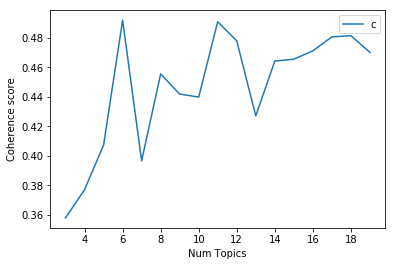

In [156]:
# start = 3
# limit = 20
# step = 1
# model_list, coherence_values = compute_coherence_values(dictionary=dictionary, corpus=corpus, texts=data_lemmatized, start=start, limit=limit, step=step)

# # Show graph
# import matplotlib.pyplot as plt
# limit=limit; start=start; step=step;
# x = range(start, limit, step)
# plt.plot(x, coherence_values)
# plt.xlabel("Num Topics")
# plt.ylabel("Coherence score")
# plt.legend(("coherence_values"), loc='best')
# plt.show()

In [29]:
# We can decrease the number of words per topic and show them separately

topn = 10 # to keep it readable
top_topics = lda_model.top_topics(corpus=corpus, dictionary=dictionary, topn=topn)

# Average topic coherence is the sum of topic coherences of all topics, divided by the number of topics.
avg_topic_coherence = sum([t[1] for t in top_topics]) / num_topics
print('Average topic coherence: %.4f.' % avg_topic_coherence)

pprint(top_topics)

Average topic coherence: -4.4855.
[([(0.109686546, 'pvv'),
   (0.0451312, 'stem'),
   (0.039113253, 'stemmen'),
   (0.025850216, 'maart'),
   (0.015224031, 'lijst'),
   (0.013537075, 'vvd'),
   (0.009524018, 'denk'),
   (0.009053747, 'weer'),
   (0.008326752, 'vandaag'),
   (0.008180459, 'rotterdam')],
  -3.369015106150296),
 ([(0.070300214, 'vvd'),
   (0.06133589, 'rutte'),
   (0.043385897, 'zijlstra'),
   (0.016708223, 'minister'),
   (0.012693101, 'weer'),
   (0.011157309, 'motie'),
   (0.010771228, 'eu'),
   (0.009022405, 'referendum'),
   (0.008835482, 'wel'),
   (0.008481288, 'nepnieuws')],
  -4.14530458672295),
 ([(0.03163312, 'vvd'),
   (0.017876908, 'pvda'),
   (0.015311725, 'gaat'),
   (0.014643145, 'rutte'),
   (0.013430973, 'kamerlid'),
   (0.011813146, 'af'),
   (0.009829851, 'groenlinks'),
   (0.009544577, 'goed'),
   (0.009110807, 'verkiezingen'),
   (0.009093776, 'tijd')],
  -4.156546395619381),
 ([(0.027257258, 'democratie'),
   (0.022732694, 'wilders'),
   (0.02207372

#### 10. Visualize topics-keywords

In [33]:
# Get frequencies
n = 10
m = 10
f = []
freq = []
for i in range(0, n) : 
    for j in range(0, m) : 
        f.append(lda_model.show_topic(i)[j][1])
    freq.append(f)
    f = []

In [34]:
# Normalize frequencies
from sklearn import preprocessing
norm = []
for i in range(0, n) : 
    X_train = np.asarray(freq[i]).reshape(-1, 1)
    min_max_scaler = preprocessing.MinMaxScaler(feature_range=(0.01, 0.99))
    X_train_minmax = min_max_scaler.fit_transform(X_train)
    norm.append(X_train_minmax)

In [35]:
# Create token - frequency dict
a = []
t = {}
for i in range(0, n) :
    for j in range(0, m) : 
        token = lda_model.show_topic(i)[j][0]
        freq = norm[i].tolist()[j][0]
        t[token] = freq
    a.append(t)
    t = {}

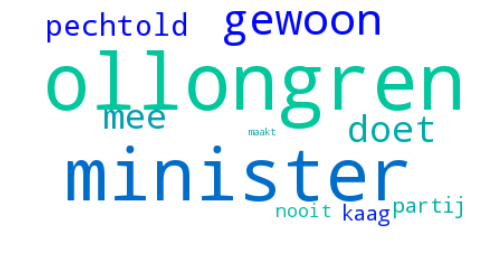

In [36]:
# Plot wordcloud
from wordcloud import WordCloud
wordcloud = WordCloud(background_color='white', colormap='winter').generate_from_frequencies(a[0])
plt.figure(figsize=(8, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

Each bubble is a topic. The larger the bubble, the more prevalent the topic.

In [ ]:
# Synonyms
# vvder - vvd?
# ga - gaat
# 

In [ ]:
# Nonsense words
# ga - go
# ...

In [ ]:
# Topic 3 vocab
# stem - voice
# maart - March
# stemmen - to vote
# lijst - list
# nida - political party
# ga - go
# waar - true
# zorg - care
# zon - such as
# tweede kamerlid - member of parliament
# kom - come
# vrijheid - freedom
# kies - choice
# opgericht - established

In [ ]:
# Topic 6 vocab
# waar - true
# ...

In [ ]:
# Case specific vocab
# nida - political party
# tweede kamerlid - member of parliament
# vrijheid -freedom

# vvder - a member of vvd
# geert_wilders - Dutch politician
# kajsa_ollongren - Dutch politician
# theo_hiddema - ...
# jan_terlouw - ...
# pechtold - alexander_pechtold - alex_pechtold?
# rutte - mark_rutte
# baudet - therry_baudet?
# sigrid_kaag

In [30]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary)
vis

C:\Users\Mikhail\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
8     -0.235727 -0.019871       1        1  11.406444
1      0.073169 -0.023926       2        1  10.991837
3     -0.187379  0.080264       3        1  10.186020
5     -0.180235 -0.164373       4        1  10.163757
9      0.097962 -0.121243       5        1  10.113652
4      0.053073  0.042956       6        1  10.026821
6      0.031421  0.108739       7        1   9.755651
2     -0.049468 -0.021870       8        1   9.735170
7      0.128550  0.317489       9        1   8.980665
0      0.268634 -0.198166      10        1   8.639982, topic_info=      Category           Freq                Term          Total  loglift  \
term                                                                        
647    Default   52074.000000                 pvv   52074.000000  30.0000   
221    Default   39475.000000                 cda   39475.000000  29.0000   
15     Default   36582.000000               rutte   36582.000000  28.0000   
34     Default  113552.000000                 vvd  113552.000000  27.0000   
640    Default   21426.000000                stem   21426.000000  26.0000   
6341   Default   27933.000000            zijlstra   27933.000000  25.0000   
66     Default   18569.000000             stemmen   18569.000000  24.0000   
13     Default   20023.000000            minister   20023.000000  23.0000   
14     Default   13188.000000           ollongren   13188.000000  22.0000   
167    Default   14186.000000          democratie   14186.000000  21.0000   
61     Default   12273.000000               maart   12273.000000  20.0000   
312    Default   39824.000000                pvda   39824.000000  19.0000   
305    Default   10217.000000              gewoon   10217.000000  18.0000   
774    Default   13786.000000             wilders   13786.000000  17.0000   
696    Default    8818.000000                even    8818.000000  16.0000   
497    Default   15458.000000           nederland   15458.000000  15.0000   
27     Default   34142.000000              partij   34142.000000  14.0000   
284    Default    8305.000000                doet    8305.000000  13.0000   
285    Default   11497.000000           rotterdam   11497.000000  12.0000   
352    Default    8101.000000                 mee    8101.000000  11.0000   
165    Default   10401.000000              willen   10401.000000  10.0000   
1043   Default    8221.000000               forum    8221.000000   9.0000   
1279   Default    9881.000000                 weg    9881.000000   8.0000   
1393   Default    7228.000000               lijst    7228.000000   7.0000   
430    Default   20727.000000            pechtold   20727.000000   6.0000   
4392   Default    8417.000000                kaag    8417.000000   5.0000   
757    Default    6614.000000        christenunie    6614.000000   4.0000   
249    Default    6478.000000            kamerlid    6478.000000   3.0000   
744    Default   24166.000000                denk   24166.000000   2.0000   
629    Default    8149.000000              zetels    8149.000000   1.0000   
...        ...            ...                 ...            ...      ...   
24531  Topic10    1552.234375           stemzeweg    1553.127686   2.4482   
1419   Topic10    1550.295898               horen    1551.189209   2.4482   
1585   Topic10    1545.690552              racist    1546.583862   2.4482   
1192   Topic10    1389.208862              turken    1390.102295   2.4481   
12801  Topic10    1339.723999    politieke_midden    1340.617432   2.4481   
847    Topic10    1333.446655         demoniseren    1334.339966   2.4481   
624    Topic10    1278.850830              meneer    1279.744141   2.4481   
1206   Topic10    1217.257446                feit    1218.150879   2.4480   
2095   Topic10    1194.226318            nijmegen    1195.119629   2.4480   
280    Topic10    1185.141479              moment    1186.034912   2.4480  